In [2]:
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import numpy as np
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
import tkinter as tk
from tkinter import filedialog
from scipy.optimize import curve_fit

#for the dialogue window when choosing the file
root = tk.Tk()
root.withdraw

#for the fun little colour coding
from typing import Tuple

def wavelength_to_rgb(nm) -> Tuple:

    '''
    Takes a wavelength of visible light
    between 380 and 780 nanometres inclusive.
    Values outside this range will raise a ValueError.
    Returns a list of corresponding RGB values.
    Based on Dan Bruton's Fortran implementation.
    '''

    if nm < 380 or nm > 780:

        return (0, 0, 0)

    gamma = 0.8
    max_intensity = 255
    factor = 0

    rgb = {"R": 0, "G": 0, "B": 0}

    if 380 <= nm <= 439:
        rgb["R"] = -(nm - 440) / (440 - 380)
        rgb["G"] = 0.0
        rgb["B"] = 1.0
    elif 440 <= nm <= 489:
        rgb["R"] = 0.0
        rgb["G"] = (nm - 440) / (490 - 440)
        rgb["B"] = 1.0
    elif 490 <= nm <= 509:
        rgb["R"] = 0.0
        rgb["G"] = 1.0
        rgb["B"] = -(nm - 510) / (510 - 490)
    elif 510 <= nm <= 579:
        rgb["R"] = (nm - 510) / (580 - 510)
        rgb["G"] = 1.0
        rgb["B"] = 0.0
    elif 580 <= nm <= 644:
        rgb["R"] = 1.0
        rgb["G"] = -(nm - 645) / (645 - 580)
        rgb["B"] = 0.0
    elif 645 <= nm <= 780:
        rgb["R"] = 1.0
        rgb["G"] = 0.0
        rgb["B"] = 0.0

    if 380 <= nm <= 419:
        factor = 0.3 + 0.7 * (nm - 380) / (420 - 380)
    elif 420 <= nm <= 700:
        factor = 1.0
    elif 701 <= nm <= 780:
        factor = 0.3 + 0.7 * (780 - nm) / (780 - 700)

    if rgb["R"] > 0:
        rgb["R"] = int(max_intensity * ((rgb["R"] * factor) ** gamma))
    else:
        rgb["R"] = 0

    if rgb["G"] > 0:
        rgb["G"] = int(max_intensity * ((rgb["G"] * factor) ** gamma))
    else:
        rgb["G"] = 0

    if rgb["B"] > 0:
        rgb["B"] = int(max_intensity * ((rgb["B"] * factor) ** gamma))
    else:
        rgb["B"] = 0

    return (rgb["R"]/255, rgb["G"]/255, rgb["B"]/255)


This code snippet is meant to take files issued from the EMspec montage in the 0307 lab at the COPL and transform the tab delimited .txt output files into graphs for visualization and potentially presentation in papers or presentations. The cell below contains a function that converts the raw .txt output to a numpy array.

In [3]:
def txt_to_data(path):
    """Generates a numpy array from the tab-delimited txt output files of the EMspec montage

    Args:
        path (string): Relative path of the txt file to be transformed

    Returns:
        data: A 2D numpy array containing the wavelengths in nm in the first column and the counts in the second column
    """
    raw_data = open(path).read()
    data = []
    for i in raw_data.split("\n")[17:-2]:
        data += [i.split("\t")]
    return np.array(data).astype(float)

Here, we create a duplicate of the data smoothed through a gaussian filter to de-noise the trace. This is used to find the fluorescence peaks exclusiveley, as other measurements can be altered by the use of filtering. The peaks are then drawn onto the spectrum in the next code cell, where they are identified with a vertical line with the approximate colour of the wavelength they repesent (absolutely not necessary but very fun to look at). These peak lines are to be used more as a tool to analyse emission than a measurement to present, though the actual measured wavelength is a data with some significance.

In [27]:
#file = filedialog.askopenfilename()
file = "C:/DATA/Université/Maitrise/PN2026/XM260205-5.txt"
print(f"file opened: {file}")
#root.withdraw()

spectrum = txt_to_data(file)
wavelengths = spectrum[:,0]
raw_counts = spectrum[:,1]


file opened: C:/DATA/Université/Maitrise/PN2026/XM260205-5.txt


In [28]:
#change the strength of the gaussian filter here! 2 seems enough for less noisy traces.
filter_sigma = 5

fil_counts = gaussian_filter1d(raw_counts, sigma = filter_sigma)
def data_2_peaks(wavel, counts, peaks):
    out = []
    for i in peaks:
        out += [[wavel[i], counts[i]]]
    return np.array(out)

peaks, props = find_peaks(fil_counts, prominence = 0.6, height = 100)
raw_peaks = data_2_peaks(wavelengths, raw_counts, peaks)
fil_peaks = data_2_peaks(wavelengths, fil_counts, peaks)

print("Coordinates for the peaks of the spectrum:")
print(raw_peaks)

Coordinates for the peaks of the spectrum:
[[ 369.68 1190.8 ]
 [ 406.56 3878.  ]
 [ 436.5  1677.7 ]
 [ 447.02 1607.  ]
 [ 464.72 2405.  ]
 [ 473.72 2187.9 ]
 [ 542.34 3883.  ]
 [ 562.   3885.  ]
 [ 572.83 3878.  ]
 [ 593.7  3887.  ]
 [ 625.46 3887.  ]
 [ 638.49 3882.  ]
 [ 647.72 3887.  ]
 [ 667.82 3885.  ]
 [ 706.   2293.5 ]
 [ 725.78 2497.6 ]
 [ 735.46 2527.7 ]
 [ 742.46 2482.4 ]
 [ 761.73 2369.8 ]
 [ 769.01 2309.1 ]
 [ 806.21 1987.2 ]
 [ 815.7  2870.7 ]
 [ 886.73  811.7 ]
 [ 895.08  818.5 ]
 [ 950.01  420.  ]
 [ 969.03   96.9 ]
 [ 979.15   76.  ]
 [1023.5    28.1 ]]


<function matplotlib.pyplot.show(close=None, block=None)>

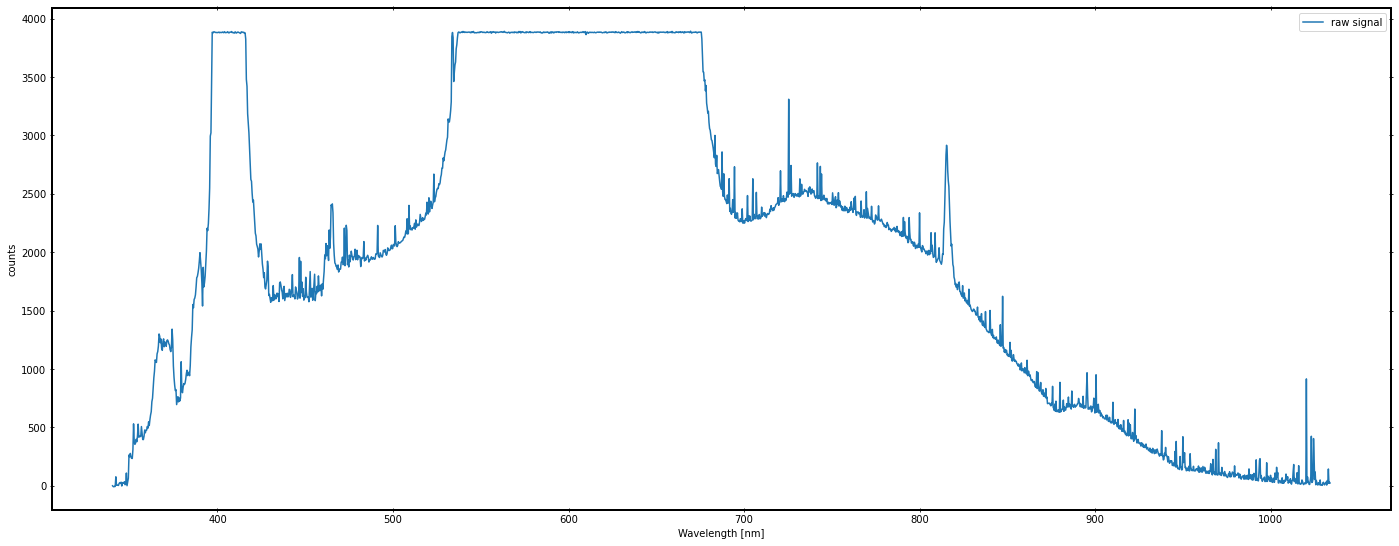

In [29]:
see_filtered_trace = False
see_peak_lines = False

fig, ax = plt.subplots(figsize=(24, 12))
fig.subplots_adjust(bottom=0.3)

y_range = np.arange(-30, raw_counts.max()+30)
ones = np.ones(y_range.shape)


plt.plot(wavelengths, raw_counts, label = "raw signal")

if see_filtered_trace:
    plt.plot(wavelengths, fil_counts, label = "filtered signal")

if see_peak_lines:
    for i in raw_peaks:
        plt.plot(ones*i[0], y_range, c = wavelength_to_rgb(i[0]), ls = "--", label = f"peak: {i[0]} nm")



ax.tick_params("both", direction = "inout", top = True, right = True)
plt.xlabel("Wavelength [nm]")
plt.ylabel("counts")
#plt.xlim(350, 750)
plt.legend()
plt.show

Cells past this one are meant for personnal use to generate personnalized figures

In [7]:
#PN 2026 spectra proportion figure
file_1 = "C:/DATA/Université/Maitrise/PN2026/XM260128-2.txt"
file_10 = "C:/DATA/Université/Maitrise/PN2026/XM260128-3.txt"
file_100 = "C:/DATA/Université/Maitrise/PN2026/XM260128-4.txt"
file_1000 = "C:/DATA/Université/Maitrise/PN2026/XM260128-7.txt"
file_0 = "C:/DATA/Université/Maitrise/PN2026/XM260130-1.txt"

spectrum_1 = txt_to_data(file_1)
spectrum_10 = txt_to_data(file_10)
spectrum_100 = txt_to_data(file_100)
spectrum_1000 = txt_to_data(file_1000)
spectrum_0 = txt_to_data(file_0)

wavelengths_PN = spectrum_1[:,0]
raw_counts_1 = spectrum_1[:,1]
raw_counts_10 = spectrum_10[:,1]
raw_counts_100 = spectrum_100[:,1]
raw_counts_1000 = spectrum_1000[:,1]
raw_counts_0 = spectrum_0[:,1]

In [8]:
def rangefinder(spectrum, range):
    start = int(np.where(abs(spectrum[:, -2] - range[0]) <= 0.25)[0])
    end = int(np.where(abs(spectrum[:, -2] - range[1]) <= 0.25)[0])
    return start, end

ex1 = rangefinder(spectrum_1, (403, 408))
print(ex1)
ex10 = rangefinder(spectrum_10, (401, 411))
ex100 = rangefinder(spectrum_100, (396, 416))
ex1000 = rangefinder(spectrum_1000, (379, 422))
ex0 = rangefinder(spectrum_0, (379, 422))

(169, 183)


<function matplotlib.pyplot.show(close=None, block=None)>

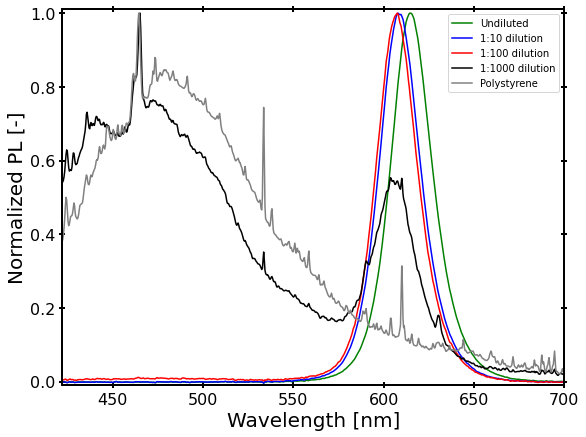

In [9]:
plt.rc('axes', linewidth=2)
fig, ax = plt.subplots(figsize=(9, 9))
fig.subplots_adjust(bottom=0.3)


#plt.plot(wavelengths_PN[:ex1[0]], gaussian_filter1d(raw_counts_1[:ex1[0]]/3666.88, sigma = 1), label = "1:1 dilution", c = "green")
#plt.plot(wavelengths_PN[:ex10[0]], gaussian_filter1d(raw_counts_10[:ex10[0]]/3393.55, sigma = 1), label = "1:10 dilution", c = "blue")
#plt.plot(wavelengths_PN[:ex100[0]], gaussian_filter1d(raw_counts_100[:ex100[0]]/3106.92, sigma = 1), label = "1:100 dilution", c = "red")
#plt.plot(wavelengths_PN[:ex1000[0]], gaussian_filter1d(raw_counts_1000[:ex1000[0]]/1293.40, sigma = 1), label = "1:1000 dilution", c = "black")
#plt.plot(wavelengths_PN[:ex0[0]], gaussian_filter1d(raw_counts_0[:ex0[0]]/2878.02, sigma = 1), label = "polystyrene", c = "gray")

plt.plot(wavelengths_PN[ex1[1]:], gaussian_filter1d(raw_counts_1[ex1[1]:]/3666.88, sigma = 1), label = "Undiluted", c = "green")
plt.plot(wavelengths_PN[ex10[1]:], gaussian_filter1d(raw_counts_10[ex10[1]:]/3393.55, sigma = 1), label = "1:10 dilution", c = "blue")
plt.plot(wavelengths_PN[ex100[1]:], gaussian_filter1d(raw_counts_100[ex100[1]:]/3106.92, sigma = 1), label = "1:100 dilution", c = "red")
plt.plot(wavelengths_PN[ex1000[1]:], gaussian_filter1d(raw_counts_1000[ex1000[1]:]/1293.40, sigma = 1), label = "1:1000 dilution", c = "black")
plt.plot(wavelengths_PN[ex0[1]:], gaussian_filter1d(raw_counts_0[ex0[1]:]/2878.02, sigma = 1), label = "Polystyrene", c = "gray")

ax.tick_params("both", direction = "inout", top = True, right = True, width = 2, length = 6, labelsize = 16)
plt.xlabel("Wavelength [nm]", fontsize = 20)
plt.ylabel("Normalized PL [-]", fontsize = 20)
plt.xlim(422, 700)
plt.ylim(-0.01, 1.01)
plt.legend()
plt.savefig("con spectrum evo.png", dpi = 600, bbox_inches = "tight")
plt.show

In [10]:
#Computing emission data (this one is a doozy)(y coords)
def emission_integrator(spectrum, range):
    start = np.where(abs(spectrum[:, -2] - range[0]) <= 0.25)[0]
    end = np.where(abs(spectrum[:, -2] - range[1]) <= 0.25)[0]
    return np.sum(spectrum[start[0]:end[0], -1])

def emission_proportion(spectrum, ex_line, QD_line):
    total = emission_integrator(spectrum, (ex_line[0], QD_line[1]))
    QD_int = emission_integrator(spectrum, QD_line)
    ex_int = emission_integrator(spectrum, ex_line)
    between = emission_integrator(spectrum, (ex_line[1], QD_line[0]))
    if between < 0:
        total = QD_int + ex_int
    return QD_int/(total-ex_int)

#1:1
ex_line_1 = (403, 408)
QD_line_1 = (556,684)
print(emission_proportion(spectrum_1, ex_line_1, QD_line_1))

#1:10
ex_line_10 = (401, 411)
QD_line_10 = (550,670)
print(emission_proportion(spectrum_10, ex_line_10, QD_line_10))

#1:100
ex_line_100 = (396, 416)
QD_line_100 = (545,667)
print(emission_proportion(spectrum_100, ex_line_100, QD_line_100))

#1:1000
ex_line_1000 = (379, 422)
QD_line_1000 = (575,660)
print(emission_proportion(spectrum_1000, ex_line_1000, QD_line_1000))



1.0
1.0
0.9736952100624866
0.2119740246027137


[0.00216121]


<function matplotlib.pyplot.show(close=None, block=None)>

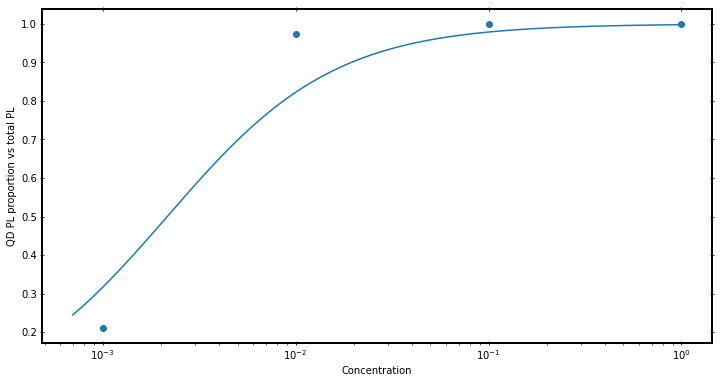

In [11]:
x = [0.001, 0.01, 0.1, 1]
y = [0.2119740246027137, 0.9736952100624866, 1, 1]
def curve(x, a):
    return x/(a+x)

popt, pcov = curve_fit(curve, x, y, (0.00001))
incert = np.sqrt(np.diag(pcov))
print(popt)

x_range = np.arange(0.0007, 1, 0.0001)

#Graphical representation of everything for a sanity check
fig, ax = plt.subplots(figsize=(12, 8))
fig.subplots_adjust(bottom=0.3)

plt.scatter(x, y)
plt.plot(x_range, curve(x_range, popt))

ax.tick_params("both", direction = "inout", top = True, right = True)
plt.xlabel("Concentration")
plt.ylabel("QD PL proportion vs total PL")
#plt.legend()
plt.xscale("log")
plt.show

In [ ]:
#This figure is just to illustrate the weird spectrums coming from the ER170309 polystyrene samples
file_a = "C:/DATA/Université/Maitrise/PN2026/XM260205-5.txt"
file_b = "C:/DATA/Université/Maitrise/PN2026/XM260205-2.txt"
file_c = "C:/DATA/Université/Maitrise/PN2026/XM260205-3.txt"
file_d = "C:/DATA/Université/Maitrise/PN2026/XM260205-4.txt"

spectrum_a = txt_to_data(file_a)
spectrum_b = txt_to_data(file_b)
spectrum_c = txt_to_data(file_c)
spectrum_d = txt_to_data(file_d)

wavelengths_ER = spectrum_a[:,0]
raw_counts_a = spectrum_a[:,1]
raw_counts_b = spectrum_b[:,1]
raw_counts_c = spectrum_c[:,1]
raw_counts_d = spectrum_d[:,1]

<function matplotlib.pyplot.show(close=None, block=None)>

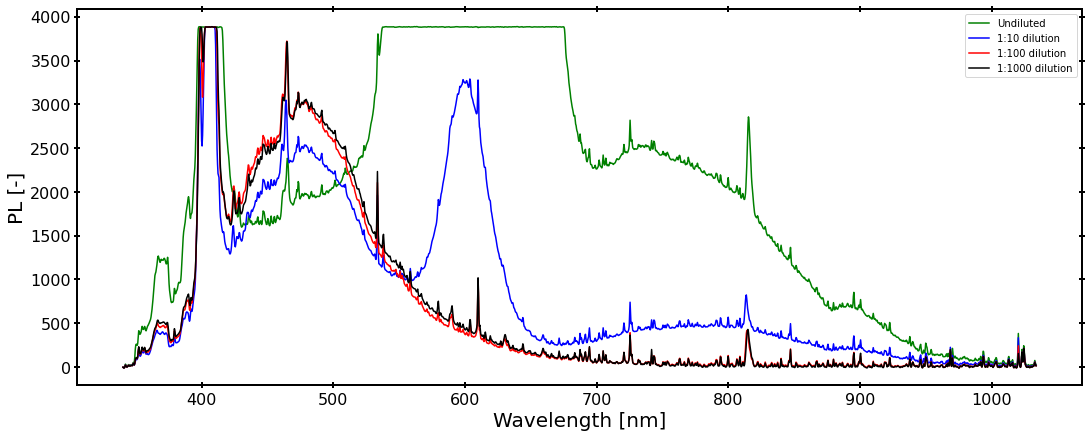

In [34]:
plt.rc('axes', linewidth=2)
fig, ax = plt.subplots(figsize=(18, 9))
fig.subplots_adjust(bottom=0.3)

plt.plot(wavelengths_ER, gaussian_filter1d(raw_counts_a, sigma = 1), label = "Undiluted", c = "green")
plt.plot(wavelengths_ER, gaussian_filter1d(raw_counts_b, sigma = 1), label = "1:10 dilution", c = "blue")
plt.plot(wavelengths_ER, gaussian_filter1d(raw_counts_c, sigma = 1), label = "1:100 dilution", c = "red")
plt.plot(wavelengths_ER, gaussian_filter1d(raw_counts_d, sigma = 1), label = "1:1000 dilution", c = "black")

ax.tick_params("both", direction = "inout", top = True, right = True, width = 2, length = 6, labelsize = 16)
plt.xlabel("Wavelength [nm]", fontsize = 20)
plt.ylabel("PL [-]", fontsize = 20)
#plt.xlim(422, 700)
#plt.ylim(-0.01, 1.01)
plt.legend()
plt.show